#**FINAL PROJECT: Looking for patterns in *E. coli* MG1655 pathway targets between antibiotics and bacteriophages**

*Analysis conducted by: **Michael Akpabey**, Thomas Chen, Ethan Kahana, and Katherine Lev *

##**Overview of the datasets:**
**Chemogenomics:**
We began with collecting two chemogenomics datasets from published scientific articles. Datasets contained drug-gene scores for antibiotics and bacteriophages targeting genome-wide targets in model organism *E. coli* MG1655.

Experiments conducted included genome-wide gene knockdown using transposon libraries and CRISPR-interference (CRISPRi) and subsequent treatment with perturbing agent (drug or phage) to measure bacterial fitness. Positive gene scores indicate that disruption of the gene had an increase in fitness (survival) after treatment with the drug or phage. Negative gene scores indicate that disruption of the gene had a decrease in fitness (survival) after treatment. Fitness scores near zero indicate no change in fitness after treatment.

**Drug-phage synergy:** Following this, we used a dataset which was obtained from running INDIGO, a machine-learning model developed to predict drug-drug synergy using chemogenomics data as input. We obtained resulting synergy scores for phages with each antibiotic.

**Pathway analysis:** Finally, we obtained several datasets from the KEGG pathway database which paired the gene names which were targeted in both phage and drug datasets to their resulting *b-numbers*, paired those b-numbers to known KEGG pathway codes, and finally paired KEGG pathway codes to the more easily readable pathway descriptions. Part of the work for this project involved data wrangling to connect all of the datasets together.

##**Instructions for running the Google Colab notebook:**

We chose to utilize Google Drive for data sharing, so that we were all working with the same datasets. As a result, we connected Google Drive to the final project Google Colab Notebook to load in the data. In order to run the code, the folder containing datasets, Google Colab notebook, and project notes should be uploaded to Google Drive and specifically stored in the 'My Drive' folder in order for all file paths to work properly. Otherwise, individual datasets can also be loaded in as needed with changes in their respective file paths.

##**Citations:**

*Antibiotic Chemogenomics Dataset:* Nichols RJ, Sen S, Choo YJ, Beltrao P, Zietek M, Chaba R, Lee S, Kazmierczak KM, Lee KJ, Wong A, Shales M, Lovett S, Winkler ME, Krogan NJ, Typas A, Gross CA. Phenotypic landscape of a bacterial cell. Cell. 2011 Jan 7;144(1):143-56.


*Bacteriophage Chemogenomics Dataset:* Mutalik VK, Adler BA, Rishi HS, Piya D, Zhong C, Koskella B, Kutter EM, Calendar R, Novichkov PS, Price MN, Deutschbauer AM, Arkin AP. High-throughput mapping of the phage resistance landscape in E. coli. PLoS Biol. 2020 Oct 13;18(10):e3000877

*INDIGO Model:* Chandrasekaran S, Cokol-Cakmak M, Sahin N, Yilancioglu K, Kazan H, Collins JJ, Cokol M. Chemogenomics and orthology-based design of antibiotic combination therapies. Mol Syst Biol. 2016 May 24;12(5):872.

Part 1: Configuring notebook environment to allow access to datasets on Google Drive, loading in libraries, and loading in datasets

In [ ]:
#load_ext autoreload
#autoreload 2
from google.colab import drive
drive.mount('/content/drive')
import os

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = None
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', 'Bioinf575_Final_Project')
print(os.listdir(GOOGLE_DRIVE_PATH))
import sys
sys.path.append(GOOGLE_DRIVE_PATH)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['Molecular Systems Biology - 2016 - Chandrasekaran - Chemogenomics and orthology%E2%80%90based design of antibiotic combination.pdf', 'data', 'BIOINF 575 Final Project Notes.gdoc', 'Project Outline.gdoc', 'final_project_ethan', 'gene_association.ipynb']


1.A: Loading numpy and pandas libraries

In [ ]:
import numpy as np
import pandas as pd

#pip install matplotlib-venn -- if needed
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import matplotlib as mpl

import networkx as nx
import seaborn as sns

1.B: Load in datasets, update the Gene column in phage_df so that it matches the Gene column in nichols_df

In [ ]:
drug_dataset_path = os.path.join(GOOGLE_DRIVE_PATH, "data/chemogenomics/nichols_filt_lowest_conc.csv")
phage_dataset_path = os.path.join(GOOGLE_DRIVE_PATH, "data/chemogenomics/phagechemgen_Nichols_genes.csv")

In [ ]:
# read in phage cutoff dataset
phage_df = pd.read_csv(phage_dataset_path, comment = "#", sep = ",")
# need to substring the phage_df gene column to only include the last four characters of the column
phage_df["Gene"] = phage_df["Gene"].str[-4:]
phage_df

,Gene,logFC T2,logFC T3,logFC T4,logFC T5,logFC T6,logFC CEV1,logFC CEV2,logFC Lmbda,logFC LZ4,logFC N4,logFC P186
0,HCHA,0.071523,0.000000,0.061822,0.059546,0.543057,1.331456,0.296270,-0.038036,0.000000,0.659644,0.326648
1,PQQL,0.109201,0.000000,0.555583,0.114625,-0.228808,0.555290,0.739345,0.078061,0.000000,0.000000,0.413903
2,YBIW,-0.043098,0.000000,0.352311,-0.013424,-0.015967,0.018610,0.059374,-0.004694,0.000000,-0.164106,0.073719
3,EUTP,-0.006841,0.000000,0.142732,0.547943,0.374175,-0.268084,-0.107680,-0.088222,0.144438,0.068517,-0.111167
4,BGLG,0.153508,0.656570,0.291706,0.058449,0.412459,0.416990,0.387120,0.148380,0.249372,0.107611,0.487372
...,...,...,...,...,...,...,...,...,...,...,...,...
3968,KGTP,-0.069541,0.179769,-0.115441,0.114746,0.081915,-0.129059,0.190797,0.008029,-0.074082,0.092497,0.021553
3969,CVRA,-0.175754,0.000000,-0.133765,0.351255,0.350506,0.872769,0.033798,0.015622,0.000000,0.000000,-0.096091
3970,YQHC,-0.187031,0.000000,-0.018406,0.214211,0.096123,0.012056,-0.254939,-0.088113,0.000000,-0.026926,0.155221
3971,TDCE,-0.156678,0.816336,0.548902,0.185669,-0.311385,-0.152073,-0.303184,-0.001900,-0.265801,0.046464,-0.007678


In [ ]:
# read in Nichols dataset
nichols_df = pd.read_csv(drug_dataset_path, comment = "#", sep = ",")
nichols_df

,Gene,ACTINOMYCIND-2.5,ACRIFLAVINE-2,AMIKACIN-0.1,AMOXICILLIN-0.5,AMPICILLIN-1.0,AZIDOTHYMIDINE-0.5,AZITHROMYCIN-0.1,BENZALKONIUM-1,BICYCLOMYCIN-1,...,NORFLOXACIN-0.01,NOVOBIOCIN-4,OXACILLIN-0.5,POLYMYXINB-1.0,RIFAMPICIN-1.0,SPECTINOMYCIN-4.0,SPIRAMYCIN-1,SULFAMETHIZOLE-100,TETRACYCLINE-0.5,TRIMETHOPRIM-0.1
0,HCHA,-0.302754,0.937110,0.723333,1.490629,-1.534203,-1.207089,1.592164,0.685394,2.293546,...,0.952183,-3.749253,1.816725,-1.907894,0.389003,-1.706455,-0.933486,0.742417,1.547495,-1.092100
1,PQQL,1.739309,-0.710681,1.683388,0.596690,0.670617,0.215072,-1.691388,-0.412914,-3.299148,...,-2.731151,-0.798466,2.066542,-0.411961,1.204424,2.142803,-0.020839,1.516899,0.247932,0.745325
2,YBIW,1.143798,0.182456,1.842290,0.541224,-1.814946,-0.061018,0.412699,-0.392697,1.819204,...,1.250029,-2.111252,1.205716,-0.764281,0.544431,1.200088,-0.923090,1.313792,1.805767,-1.265369
3,EUTP,0.362145,-0.885666,1.178999,-1.251817,0.203098,-0.781486,0.833082,-1.593395,-2.037742,...,-1.778046,-1.762977,0.871267,-0.943299,0.450574,0.087361,1.576894,0.001213,0.143471,0.225981
4,BGLG,0.675163,0.769263,-0.606323,0.817173,-0.289386,-1.122390,-0.428128,0.957925,2.057641,...,1.196223,-1.716463,1.592241,-0.480197,1.050146,-0.824498,0.573022,-0.917358,-0.459961,-0.722024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3974,KGTP,-0.282929,1.417514,1.423671,-0.521315,-0.556174,0.336977,-0.102532,0.907432,-0.933985,...,-0.693474,-1.014517,-2.954355,1.371398,1.336207,-0.048224,-3.597711,0.323227,-1.776138,-2.495283
3975,CVRA,-3.608220,-0.584951,-0.639217,-1.146380,-1.473892,0.807125,-0.752837,-1.265918,0.277603,...,-0.392082,-0.444484,-0.253304,-0.135994,-0.363071,0.919332,-0.975656,1.894160,1.002290,-0.227762
3976,YQHC,-0.464842,-0.073111,-0.415336,-0.305822,0.620440,0.009900,1.073510,0.049137,-1.057720,...,0.383907,-0.181253,0.800236,-1.732964,-1.551889,-0.369377,-0.332826,1.361486,1.729593,-0.663056
3977,TDCE,0.337485,0.855881,0.567370,-1.199121,-0.772846,-0.441946,0.648266,-0.058352,0.176839,...,-0.785930,-0.257049,1.390457,-0.426241,-0.951995,0.609532,0.381213,0.222326,-0.296482,-0.159128


Part 2: Examining the datasets with basic statistical information (mean, median, range, min, max)

2.A: Function to identify minimum scores for each phage and drug



In [ ]:
# min gene for each drug
def min_gene_each_drug(df):
    # Extract drug names from the first column
    drugs = df.iloc[0, 1:]

    # Convert the rest of the DataFrame to numeric, handling non-numeric values
    df.iloc[:, 1:] = df.iloc[:, 1:].apply(pd.to_numeric, errors='coerce')

    # Find the index of the minimum value for each drug across all genes
    min_gene_indices = df.iloc[:, 1:].idxmin()

    # Extract the corresponding gene names using the indices
    min_genes = df.iloc[min_gene_indices.values, 0]

    # Create a DataFrame from the result
    result_df = pd.DataFrame({'Drugs': df.columns[1:],'Min_Genes': min_genes.values})

    return result_df

In [ ]:
min_gene_each_drug(phage_df)

,Drugs,Min_Genes
0,logFC T2,YCJT
1,logFC T3,PDHR
2,logFC T4,LIGB
3,logFC T5,PSTB
4,logFC T6,CBRA
5,logFC CEV1,RPLA
6,logFC CEV2,PSTB
7,logFC Lmbda,PCNB
8,logFC LZ4,PROB
9,logFC N4,ATPI


In [ ]:
min_gene_each_drug(nichols_df)

,Drugs,Min_Genes
0,ACTINOMYCIND-2.5,GUAB
1,ACRIFLAVINE-2,TOLC
2,AMIKACIN-0.1,SPA
3,AMOXICILLIN-0.5,UXUR
4,AMPICILLIN-1.0,Allele
...,...,...
87,SPECTINOMYCIN-4.0,RYFC
88,SPIRAMYCIN-1,Allele
89,SULFAMETHIZOLE-100,NUDB
90,TETRACYCLINE-0.5,SPA


2.B: Function to identify maximum scores for each phage and drug

In [ ]:
# Max gene each drug
def max_gene_each_drug(df):
    # Extract drug names from the first column
    drugs = df.iloc[0, 1:]

    # Convert the rest of the DataFrame to numeric, handling non-numeric values
    df.iloc[:, 1:] = df.iloc[:, 1:].apply(pd.to_numeric, errors='coerce')

    # Find the index of the minimum value for each drug across all genes
    max_gene_indices = df.iloc[:, 1:].idxmax()

    # Extract the corresponding gene names using the indices
    max_genes = df.iloc[max_gene_indices.values, 0]

    # Create a DataFrame from the result
    result_df = pd.DataFrame({'Drugs': df.columns[1:],'Max_Genes': max_genes.values})

    return result_df

In [ ]:
# test for nichols_df
max_gene_each_drug(nichols_df)

,Drugs,Max_Genes
0,ACTINOMYCIND-2.5,DNAQ
1,ACRIFLAVINE-2,PURD
2,AMIKACIN-0.1,PPIB
3,AMOXICILLIN-0.5,YCHJ
4,AMPICILLIN-1.0,DAM
...,...,...
87,SPECTINOMYCIN-4.0,CMR
88,SPIRAMYCIN-1,YFCA
89,SULFAMETHIZOLE-100,LON
90,TETRACYCLINE-0.5,LPCA


In [ ]:
# test for phage_df
max_gene_each_drug(phage_df)

,Drugs,Max_Genes
0,logFC T2,FADL
1,logFC T3,YEDY
2,logFC T4,OMPC
3,logFC T5,FHUA
4,logFC T6,-TSX
5,logFC CEV1,OMPF
6,logFC CEV2,FHUA
7,logFC Lmbda,LAMB
8,logFC LZ4,OMPF
9,logFC N4,YDFW


2.C: Function to identify the range of the scores for each phage and drug

In [ ]:
# range per drug
def range_per_drug(df):
    result_df = pd.DataFrame(columns=['Column', 'Range'])
    # Iterate through each column in the DataFrame
    for column_name in df.columns:
        # Extract the values of the current column
        column_values = df[column_name]
        # need to convert to numeric
        column_values = pd.to_numeric(df[column_name], errors='coerce')
        # Calculate the range for the current column
        column_range = float(column_values.max()) - float(column_values.min())
        # Append the column name and its range to the result DataFrame (use concat so don't get a warning)
        result_df = pd.concat([result_df, pd.DataFrame({'Column': [column_name], 'Range': [column_range]})], ignore_index=True)
    # want to exclude the 'Gene' row (not a datapoint)
    result_df = result_df[result_df['Column'] != 'Gene']
    # sort the df
    result_df = result_df.sort_values(by='Range', ascending=False)
    return result_df

In [ ]:
range_per_drug(nichols_df)

,Column,Range
14,CEFOXITIN-0.5,45.801882
68,VERAPAMIL-0.1,44.376749
31,ETHIDIUMBROMIDE-2,44.099133
16,CEFSULODIN-6.0,38.267688
52,PROCAINE-1,38.182527
...,...,...
53,PUROMYCIN-1,9.520099
50,PEROXIDE-0.1,9.339618
12,CCCP-0.1,9.333952
26,DOXORUBICIN-1.0,9.055880


In [ ]:
range_per_drug(phage_df)

,Column,Range
6,logFC CEV1,13.276543
2,logFC T3,10.724581
3,logFC T4,8.893334
8,logFC Lmbda,6.808032
9,logFC LZ4,6.278465
7,logFC CEV2,6.135316
4,logFC T5,5.820718
10,logFC N4,5.191043
11,logFC P186,4.160302
5,logFC T6,3.985800


Part 3: Examining the dataset for outlier drugs

3.A: For drugs with the largest range, what are the genes being targeted - is there a certain gene which consistently results in high gene scores?

In [ ]:
# find the max genes of the top 5 drugs that have the biggest range
def top_5_max_from_range(df):
    result_df = range_per_drug(df)
    max_gene_result = max_gene_each_drug(df)
    top_5_drugs = result_df.head(5)
    top_5_drugs
    max_genes_top_5 = []

    for drug in top_5_drugs['Column']:
         # Get the maximum gene for the current drug
        max_gene = max_gene_result.loc[max_gene_result['Drugs'] == drug, 'Max_Genes'].values[0]

        # Append the result to the list
        max_genes_top_5.append({'Drug': drug, 'Max_Gene': max_gene})
    return max_genes_top_5

In [ ]:
# test on nichols_df
# since all max genes different, this is good because there is no single outlier
# Y... genes seem to be top genes
top_5_max_from_range(nichols_df)

[{'Drug': 'CEFOXITIN-0.5', 'Max_Gene': 'YCHJ'},
 {'Drug': 'VERAPAMIL-0.1', 'Max_Gene': 'FIS'},
 {'Drug': 'ETHIDIUMBROMIDE-2', 'Max_Gene': 'YBGL'},
 {'Drug': 'CEFSULODIN-6.0', 'Max_Gene': 'YFDY'},
 {'Drug': 'PROCAINE-1', 'Max_Gene': 'DNAQ'}]

3.B: When running the function for the bacteriophage dataset, we see 2 outer membrane porins (OmpF and OmpC) where disruption consistently result in high gene scores, indicating bacterial survival.

This finding is interesting, as other studies have shown that outer membrane porins may serve as receptors for phage binding to the bacterial cell wall.  

In [ ]:
# test on phage_df (overall range is smaller)
# OMPF repeats 2x, OMPC once, so check out OMP... genes (this makes sense)
top_5_max_from_range(phage_df)

[{'Drug': 'logFC CEV1', 'Max_Gene': 'OMPF'},
 {'Drug': 'logFC T3', 'Max_Gene': 'YEDY'},
 {'Drug': 'logFC T4', 'Max_Gene': 'OMPC'},
 {'Drug': 'logFC Lmbda', 'Max_Gene': 'LAMB'},
 {'Drug': 'logFC LZ4', 'Max_Gene': 'OMPF'}]

3.C: Defining the genes for lowest gene scores.

In [ ]:
# now do the same function but for min
def top_5_min_from_range(df):
    result_df = range_per_drug(df)
    min_gene_result = min_gene_each_drug(df)
    bottom_5_drugs = result_df.head(5)
    bottom_5_drugs
    min_genes_top_5 = []

    for drug in bottom_5_drugs['Column']:
         # Get the maximum gene for the current drug
        min_gene = min_gene_result.loc[min_gene_result['Drugs'] == drug, 'Min_Genes'].values[0]

        # Append the result to the list
        min_genes_top_5.append({'Drug': drug, 'Min_Gene': min_gene})
    return min_genes_top_5

In [ ]:
# GUAB repeats
# YCFM repeats
top_5_min_from_range(nichols_df)

[{'Drug': 'CEFOXITIN-0.5', 'Min_Gene': 'YCFM'},
 {'Drug': 'VERAPAMIL-0.1', 'Min_Gene': 'GUAB'},
 {'Drug': 'ETHIDIUMBROMIDE-2', 'Min_Gene': 'ACRA'},
 {'Drug': 'CEFSULODIN-6.0', 'Min_Gene': 'YCFM'},
 {'Drug': 'PROCAINE-1', 'Min_Gene': 'GUAB'}]

In [ ]:
# No repeats, but look into genes starting with P...
top_5_min_from_range(phage_df)

[{'Drug': 'logFC CEV1', 'Min_Gene': 'RPLA'},
 {'Drug': 'logFC T3', 'Min_Gene': 'PDHR'},
 {'Drug': 'logFC T4', 'Min_Gene': 'LIGB'},
 {'Drug': 'logFC Lmbda', 'Min_Gene': 'PCNB'},
 {'Drug': 'logFC LZ4', 'Min_Gene': 'PROB'}]

3.D. Code to convert dataframe to dictionary for ease of use.

In [ ]:
def dataframe_to_dict(dataframe):
    gene_data = {}

    for index, row in dataframe.iterrows():
        gene_name = row['Gene']
        gene_data[gene_name] = {agent: row[agent] for agent in row.index if agent != 'Gene'}

    return gene_data

#Convert DataFrame to a dictionary
nichols_dict = dataframe_to_dict(nichols_df)

#Display the dictionary
print(nichols_dict)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Part 4: Determining number of overlapping genes between bacteriophage and antibiotic datasets.

In [ ]:
# Compute Overlapping Genes

# Determine the top 5 overlapping genes between bacteriophages and antibiotics datasets.

# Functions that will take in a specific antibiotics name and a specific phage name that computes genes that have positive fitness score and overlap between the antibiotics/phage.
#Once we find the overlaping, non-zero genes between the two lists, we will rank the fitness score and compute the top 5 genes from both the antibiotics
#and phage colume.


def compute_postive_fc_overlap (antibiotics, phage):

  antibiotics_name = str(antibiotics)
  phage_name = str(phage)

  positive_fc_phage= phage_df[phage_df[phage_name] > 0][["Gene", phage_name]]
  positive_fc_antibiotics= nichols_df[nichols_df[antibiotics_name] > 0][["Gene", antibiotics_name]]
  merged_positve_fc=positive_fc_antibiotics.merge(positive_fc_phage, how = "inner")
  top_5_genes_antibiotics = merged_positve_fc.sort_values(by=antibiotics_name,ascending=False).head(5)["Gene"].values
  top_5_genes_phage=merged_positve_fc.sort_values(by=phage_name, ascending=False).head(5)["Gene"].values

  return top_5_genes_antibiotics, top_5_genes_phage

#top_5_genes_antibiotics_positive_fc, top_5_genes_phage_positive_fc = compute_postive_fc_overlap ("ACTINOMYCIND-2.5","logFC CEV2")
top5= compute_postive_fc_overlap ("ACTINOMYCIND-2.5","logFC CEV2")
top5

(array(['YEHS', 'GREA', 'YTFQ', 'DCTA', 'YHCA'], dtype=object),
 array(['FHUA', 'YEJL', 'FABH', 'DDLB', 'YBIS'], dtype=object))

In [ ]:
# Similar function as above, except we are computing the bottom 5 genes

def compute_negative_fc_overlap (antibiotics, phage):

  antibiotics_name = str(antibiotics)
  phage_name = str(phage)

  positive_fc_phage= phage_df[phage_df[phage_name] < 0][["Gene", phage_name]]
  positive_fc_antibiotics= nichols_df[nichols_df[antibiotics_name] < 0][["Gene", antibiotics_name]]
  merged_positve_fc=positive_fc_antibiotics.merge(positive_fc_phage, how = "inner")
  bottom_5_genes_antibiotics = merged_positve_fc.sort_values(by=antibiotics_name,ascending=True).head(5)["Gene"].values
  bottom_5_genes_phage=merged_positve_fc.sort_values(by=phage_name, ascending=True).head(5)["Gene"].values

  return bottom_5_genes_antibiotics, bottom_5_genes_phage

#bottom_5_genes_antibiotics_negative_fc, bottom_5_genes_phage_negative_fc = compute_negative_fc_overlap ("ACTINOMYCIND-2.5","logFC CEV2")
bottom5= compute_negative_fc_overlap ("ACTINOMYCIND-2.5","logFC CEV2")
bottom5

(array(['RPLA', 'ATPB', 'HDFR', 'TONB', 'PURF'], dtype=object),
 array(['PSTB', 'YHHZ', 'YEGQ', 'YDAS', 'QUEA'], dtype=object))

In [ ]:
# Writting a for-loop to create all combinations of antibioticis and phages to put into my function

In [ ]:
phage_no_first_column = phage_df.iloc[:, 1:]
ab_no_first_column = nichols_df.iloc[:, 1:]

# Get column names from both DataFrames
columns_phage = phage_no_first_column.columns
columns_abs= ab_no_first_column.columns

# Create a list to store all combinations
all_combinations = []

# Nested for-loops to iterate through all combinations
for ab in columns_abs:
    for phage in columns_phage:
        combination = (ab, phage)
        all_combinations.append(combination)


In [ ]:
# Feeding all possible combination into the top gene/bottom gene function
# Putting the output of the function into the panda data frame

import pandas as pd
column1 = []
column2 = []
column3 = []
column4 = []

for elem in all_combinations:
  ab_for_testing = elem[0]
  phage_for_testing = elem[1]
  top_5_abs, top_5_phage = compute_postive_fc_overlap (ab_for_testing, phage_for_testing)
  column1.append (top_5_abs)
  column2.append (top_5_phage)
  bottom_5_abs, bottom_5_phage = compute_negative_fc_overlap (ab_for_testing, phage_for_testing)
  column3.append (bottom_5_abs)
  column4.append (bottom_5_phage)

In [ ]:
colume_name = ["top_5_gene_from_antibiotics","top_5_gene_from_phage","bottom_5_gene_from_antibiotics","bottom_5_gene_from_phage",]
result_df = pd.DataFrame(columns = colume_name, index = all_combinations)
result_df["top_5_gene_from_antibiotics"] = column1
result_df["top_5_gene_from_phage"] = column2
result_df["bottom_5_gene_from_antibiotics"] = column3
result_df["bottom_5_gene_from_phage"] = column4

result_df

,top_5_gene_from_antibiotics,top_5_gene_from_phage,bottom_5_gene_from_antibiotics,bottom_5_gene_from_phage
"(ACTINOMYCIND-2.5, logFC T2)","[RLUA, DUSA, YCHJ, YDAN, YTFQ]","[YEJL, YNBC, DUSA, YEDY, YFAD]","[GUAB, PURD, PURM, CARB, PURE]","[RPSF, YIAA, YFAE, YAGE, YDFN]"
"(ACTINOMYCIND-2.5, logFC T3)","[GREA, HYAB, GALK, YBHL, MALF]","[YEDY, YEJL, HOKE, YJDO, ASTC]","[PURM, ATPD, YECC, ARGR, HEMX]","[PDHR, RHAS, FIMA, THIH, PROV]"
"(ACTINOMYCIND-2.5, logFC T4)","[DUSA, YDAN, YEHS, GREA, YTFQ]","[YEJL, YIBA, YFCI, YEDY, YBDN]","[GUAB, PYRE, PURM, CARB, PURE]","[KPTA, MUTL, YNEM, YFJJ, CMOA]"
"(ACTINOMYCIND-2.5, logFC T5)","[RLUA, YCHJ, YDAN, GREA, YTFQ]","[FHUA, HUPB, DUSB, YMFI, YJHC]","[GUAB, PYRE, PURD, PYRD, PURL]","[PSTB, PHOU, YHEU, RECC, YAGF]"
"(ACTINOMYCIND-2.5, logFC T6)","[DNAQ, RLUA, YCHJ, YDAN, GREA]","[YEJL, RLUC, YNBC, IRAM, YEGP]","[GUAB, PURD, PURE, RPLA, EMTA]","[CBRA, YCJS, PEPB, YJBF, FIXC]"
...,...,...,...,...
"(TRIMETHOPRIM-0.1, logFC CEV2)","[PDXH, ENVC, FLHE, GLPT, UBIE]","[YEJL, FABH, YMIA, DDLB, YBIS]","[ACRA, ACRB, NUDB, TOLC, METJ]","[YHHZ, YBIX, YDAS, PPIA, TEHB]"
"(TRIMETHOPRIM-0.1, logFC Lmbda)","[DNAJ, FLHE, GLPT, LIPA, ASPA]","[MALK, YEJL, PSTB, RPME, TREC]","[ACRA, ACRB, NUDB, FOLB, TOLC]","[THYA, RPMI, YFAE, RPMG, CYDB]"
"(TRIMETHOPRIM-0.1, logFC LZ4)","[FLHE, GLPT, ASPA, UBIH, SSRA]","[OMPF, YEJL, YEDY, YAFQ, YHHM]","[METJ, RBSB, CPXA, KDPB, YCAI]","[PROB, RHAS, UXAA, CYDB, AROH]"
"(TRIMETHOPRIM-0.1, logFC N4)","[FLHE, GLPT, LIPA, UBIE, ASPA]","[YDFW, YECT, NFRB, YBCF, YEDP]","[ACRB, NUDB, FOLB, TOLC, PURN]","[ATPI, ULAA, AGAS, ABRB, FLGF]"


Part 5: Determining overlapping pathways that the previously identified genes are in

In [ ]:
#Loading datasets
pathway_gene_path = os.path.join(GOOGLE_DRIVE_PATH, "data/pathway_analysis/gene_pathway_df.xlsx")
K_path = os.path.join(GOOGLE_DRIVE_PATH, "data/pathway_analysis/KEGG_path.xlsx")
B_path = os.path.join(GOOGLE_DRIVE_PATH, "data/pathway_analysis/gene_bnum_eck_Nichols.xlsx")


pathways_gene = pd.read_excel(pathway_gene_path) #Connection between genes(b_nums) and pathways
KEGG_path = pd.read_excel(K_path) #Provides the name of the pathways
B_nums = pd.read_excel(B_path) #Connects genes to their b_nums

#Data cleaning steps

#Replacing prefixes in the origianl dataframe
pathways_gene['Gene'] = pathways_gene['Gene'].str.replace('eco:', '', regex=False)
pathways_gene['Pathway'] = pathways_gene['Pathway'].str.replace('path:', '', regex=False)

KEGG_path['Pathway'] = KEGG_path['Pathway'].str.replace('- Escherichia coli K-12 MG1655', '', regex=False)



In [ ]:
B_nums.head()

,bnums,eck,genes
0,b1967,ECK1963,hchA
1,b1494,ECK1488,pqqL
2,b0823,ECK0813,ybiW
3,b2461,ECK2456,eutP
4,b3723,ECK3716,bglG


In [ ]:
B_nums['genes'] = B_nums['genes'].str.lower()
B_nums.head()

,bnums,eck,genes
0,b1967,ECK1963,hcha
1,b1494,ECK1488,pqql
2,b0823,ECK0813,ybiw
3,b2461,ECK2456,eutp
4,b3723,ECK3716,bglg


In [ ]:

def iden_pathways(list_abx_genes, list_phag_genes):

    list_abx_genes_lower = [gene.lower() for gene in list_abx_genes]
    list_phag_genes_lower = [gene.lower() for gene in list_phag_genes]

    gene_bn_abx = []
    for gene in list_abx_genes_lower:
        nums = B_nums[B_nums['genes'] == gene]['bnums']
        for num in nums:
            gene_bn_abx.append(num)

    path_g_abx = []
    for gen in gene_bn_abx:
        paths = pathways_gene[pathways_gene["Gene"] == gen]["Pathway"]
        for path in paths:
            path_g_abx.append(path)

    path_names_abx = []
    for p in path_g_abx:
        path_names = KEGG_path[KEGG_path["ID"] == p]["Pathway"]
        for path_name in path_names:
            if path_name in path_names_abx:
                pass
            else:
                path_names_abx.append(path_name)

    gene_bn_phag = []
    for gene in list_phag_genes_lower:
        nums_b = B_nums[B_nums['genes'] == gene]['bnums']
        for num_b in nums_b:
            gene_bn_phag.append(num_b)

    path_g_phag = []
    for gen in gene_bn_phag:
        paths_b = pathways_gene[pathways_gene["Gene"] == gen ]["Pathway"]
        for path_b in paths_b:
            path_g_phag.append(path_b)

    path_names_phag = []
    for p in path_g_phag:
        path_names_b = KEGG_path[KEGG_path["ID"] == p]["Pathway"]
        for path_name_b in path_names_b:
            if path_name_b in path_names_phag:
                pass
            else:
                path_names_phag.append(path_name_b)

    return path_names_abx, path_names_phag


In [ ]:
pth_abx, pth_phag = iden_pathways(top5[0], top5[1])
print(pth_abx)
print(pth_phag)

['ABC transporters  ', 'Two-component system  ']
['Fatty acid biosynthesis  ', 'Metabolic pathways  ', 'Fatty acid metabolism  ', 'D-Amino acid metabolism  ', 'Peptidoglycan biosynthesis  ', 'Vancomycin resistance  ']


In [ ]:
def path_overlap(path_names_abx, path_names_phag):
  set_abx = set(path_names_abx)
  set_phag = set(path_names_phag)

  intersection = set_abx.intersection(set_phag)

  return list(intersection)

Part 6: Visualizing the overlapping pathways using a Venn Diagram

In [ ]:
def path_venn(path_names_abx, path_names_phag):

    set_abx = set(path_names_abx)
    set_phag = set(path_names_phag)

    #intersection = set_abx.intersection(set_phag)
    #print(intersection)

    venn2([set_abx, set_phag], ('ABX', 'PHAG'))
    plt.show()

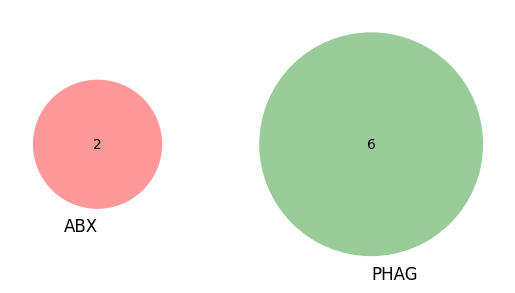

In [ ]:
path_venn(pth_abx, pth_phag)

In [ ]:
#Creation of a for loop that identifies all possible overlapping pathways
pathways_data = []

for Drug_comb, row in result_df.iterrows():
  #print(row["top_5_gene_from_phage"])
  path_top_abx, path_top_phage = iden_pathways(row["top_5_gene_from_antibiotics"], row["top_5_gene_from_phage"])
  path_low_abx, path_low_phage = iden_pathways(row["bottom_5_gene_from_antibiotics"], row["bottom_5_gene_from_phage"])

  pathways_data.append((Drug_comb, path_top_abx, path_top_phage, path_low_abx, path_low_phage))


pathways_df = pd.DataFrame(pathways_data, columns=['Drug_phage_combination', 'path_top_abx', 'path_top_phage', 'path_low_abx', 'path_low_phage'])
pathways_df

,Drug_phage_combination,path_top_abx,path_top_phage,path_low_abx,path_low_phage
0,"(ACTINOMYCIND-2.5, logFC T2)",[ABC transporters ],[],"[Purine metabolism , Metabolic pathways , Bi...","[Ribosome , Pentose and glucuronate interconv..."
1,"(ACTINOMYCIND-2.5, logFC T3)","[Nitrotoluene degradation , Microbial metabol...","[Arginine and proline metabolism , Metabolic ...","[Purine metabolism , Metabolic pathways , Bi...","[Thiamine metabolism , Metabolic pathways , ..."
2,"(ACTINOMYCIND-2.5, logFC T4)",[ABC transporters ],[],"[Purine metabolism , Metabolic pathways , Bi...",[Mismatch repair ]
3,"(ACTINOMYCIND-2.5, logFC T5)",[ABC transporters ],[],"[Purine metabolism , Metabolic pathways , Bi...","[ABC transporters , Homologous recombination ..."
4,"(ACTINOMYCIND-2.5, logFC T6)","[DNA replication , Mismatch repair , Homolog...",[],"[Purine metabolism , Metabolic pathways , Bi...","[Glutathione metabolism , Metabolic pathways ]"
...,...,...,...,...,...
1007,"(TRIMETHOPRIM-0.1, logFC CEV2)","[Vitamin B6 metabolism , Metabolic pathways ...","[Fatty acid biosynthesis , Metabolic pathways...","[beta-Lactam resistance , Cationic antimicrob...",[Cationic antimicrobial peptide (CAMP) resista...
1008,"(TRIMETHOPRIM-0.1, logFC Lmbda)","[Flagellar assembly , Lipoic acid metabolism ...","[ABC transporters , Ribosome , Starch and su...","[beta-Lactam resistance , Cationic antimicrob...","[Pyrimidine metabolism , One carbon pool by f..."
1009,"(TRIMETHOPRIM-0.1, logFC LZ4)","[Flagellar assembly , Alanine, aspartate and ...","[beta-Lactam resistance , Two-component syste...","[ABC transporters , Bacterial chemotaxis , C...","[Arginine and proline metabolism , Carbapenem..."
1010,"(TRIMETHOPRIM-0.1, logFC N4)","[Flagellar assembly , Lipoic acid metabolism ...","[Arginine biosynthesis , Purine metabolism ,...","[beta-Lactam resistance , Cationic antimicrob...","[Ascorbate and aldarate metabolism , Metaboli..."


In [ ]:
overlap_data = []

for _, row in pathways_df.iterrows():

  overlap_top_genes = path_overlap(row["path_top_abx"], row["path_top_phage"])
  overlap_bottom_genes = path_overlap(row["path_low_abx"], row["path_low_phage"])
  Drug_comb = row["Drug_phage_combination"]

  overlap_data.append((Drug_comb, overlap_top_genes, overlap_bottom_genes))


pathways_overlap_df = pd.DataFrame(overlap_data, columns=['Drug_phage_combination', 'overlap_top_genes', 'overlap_bottom_genes'])
pathways_overlap_df

,Drug_phage_combination,overlap_top_genes,overlap_bottom_genes
0,"(ACTINOMYCIND-2.5, logFC T2)",[],[Metabolic pathways ]
1,"(ACTINOMYCIND-2.5, logFC T3)",[Metabolic pathways ],"[Metabolic pathways , Biosynthesis of cofacto..."
2,"(ACTINOMYCIND-2.5, logFC T4)",[],[]
3,"(ACTINOMYCIND-2.5, logFC T5)",[],[Metabolic pathways ]
4,"(ACTINOMYCIND-2.5, logFC T6)",[],[Metabolic pathways ]
...,...,...,...
1007,"(TRIMETHOPRIM-0.1, logFC CEV2)",[Metabolic pathways ],[Cationic antimicrobial peptide (CAMP) resista...
1008,"(TRIMETHOPRIM-0.1, logFC Lmbda)",[Metabolic pathways ],"[Metabolic pathways , Two-component system ]"
1009,"(TRIMETHOPRIM-0.1, logFC LZ4)",[],[Two-component system ]
1010,"(TRIMETHOPRIM-0.1, logFC N4)",[Metabolic pathways ],[Metabolic pathways ]


Part 7: Visualizing an association network of drugs/antibiotics. Drugs and antibiotics are represented by nodes in the network and are connected by an edge if the drug/antibiotic have top and bottom genes that are in the same pathway.


In this visualization, we are looking for if the genes that, when disrupted, cause some effect in drug activity (highly positive or highly negative fitness scores as described and identified above).

In [ ]:
#Step 1: Getting the data to match
#convert 'genes' to all uppercase
B_nums['genes'] = B_nums['genes'].str.upper()

#convert 'genes' to 'Gene' to match
B_nums = B_nums.rename(columns={'genes': 'Gene'})

B_nums

#remove 'eco:' from 'Gene' column
pathways_gene['Gene'] = pathways_gene['Gene'].str.replace('eco:', '')

#remove 'path:' from 'Pathway' column
pathways_gene['Pathway'] = pathways_gene['Pathway'].str.replace('path:', '')
pathways_gene

,Pathway,Gene
0,eco00010,b0114
1,eco00010,b0115
2,eco00010,b0116
3,eco00010,b0325
4,eco00010,b0356
...,...,...
4739,eco04122,b3344
4740,eco04122,b3345
4741,eco04122,b3470
4742,eco04122,b3992


In [ ]:
#Step 2: Mapping gene names to b-numbers
gene_to_bnumber_dict = dict(zip(B_nums['Gene'], B_nums['bnums']))

In [ ]:
#Step 3: Creating the gene association network
gene_network = nx.Graph()

# Retrieve values from the 'Gene' column as lists
nichols_genes = nichols_df['Gene'].tolist()
phage_genes = phage_df['Gene'].tolist()

#Combine all genes
all_genes = set(nichols_genes + phage_genes)

#Collect all genes from gene_to_bnumber_dict
valid_genes = set(gene_to_bnumber_dict.keys())

#Filter genes that exist in gene_to_bnumber_dict from your dataset genes
#genes_with_b_numbers = [gene for gene in genes if gene in valid_genes]

#Add nodes to the gene_network graph
for drug in pathways_overlap_df['Drug_phage_combination'].unique():
    gene_network.add_node(drug, type='drug')

#Defining a function to add edges between drugs-phage combination nodes with common pathways
def add_edges_for_shared_pathways(df, column, graph):

    pathway_dict = {}
    for index, row in df.iterrows():
        drug = row['Drug_phage_combination']
        pathways = row[column]


        for pathway in pathways:
            if pathway not in pathway_dict:
                pathway_dict[pathway] = [drug]
            else:
                # If the pathway is already associated with a drug, add an edge between the drugs
                for existing_drug in pathway_dict[pathway]:
                    graph.add_edge(drug, existing_drug, pathway=pathway)
                pathway_dict[pathway].append(drug)

#Adding edges for top genes pathways
add_edges_for_shared_pathways(pathways_overlap_df, 'overlap_top_genes', gene_network)

#Adding edges for bottom genes pathways
add_edges_for_shared_pathways(pathways_overlap_df, 'overlap_bottom_genes', gene_network)



In [ ]:
#Create edges based on shared pathways
for gene in genes_with_b_numbers:
    b_number = gene_to_bnumber_dict[gene]
    if b_number in gene_path['Gene'].tolist():
        pathways = gene_path[gene_path['Gene'] == b_number]['Pathway'].tolist()
        for pathway in pathways:
            if pathway in KEGG_path['ID'].tolist():
                pathway_name = KEGG_path[KEGG_path['ID'] == pathway]['Pathway'].values[0]
                connected_genes = gene_path[gene_path['Pathway'] == pathway]['Gene'].tolist()
                connected_genes = [g for g in connected_genes if g != b_number and g in gene_to_bnumber_dict.values()]
                gene_network.add_edges_from([(gene, connected_gene) for connected_gene in connected_genes])

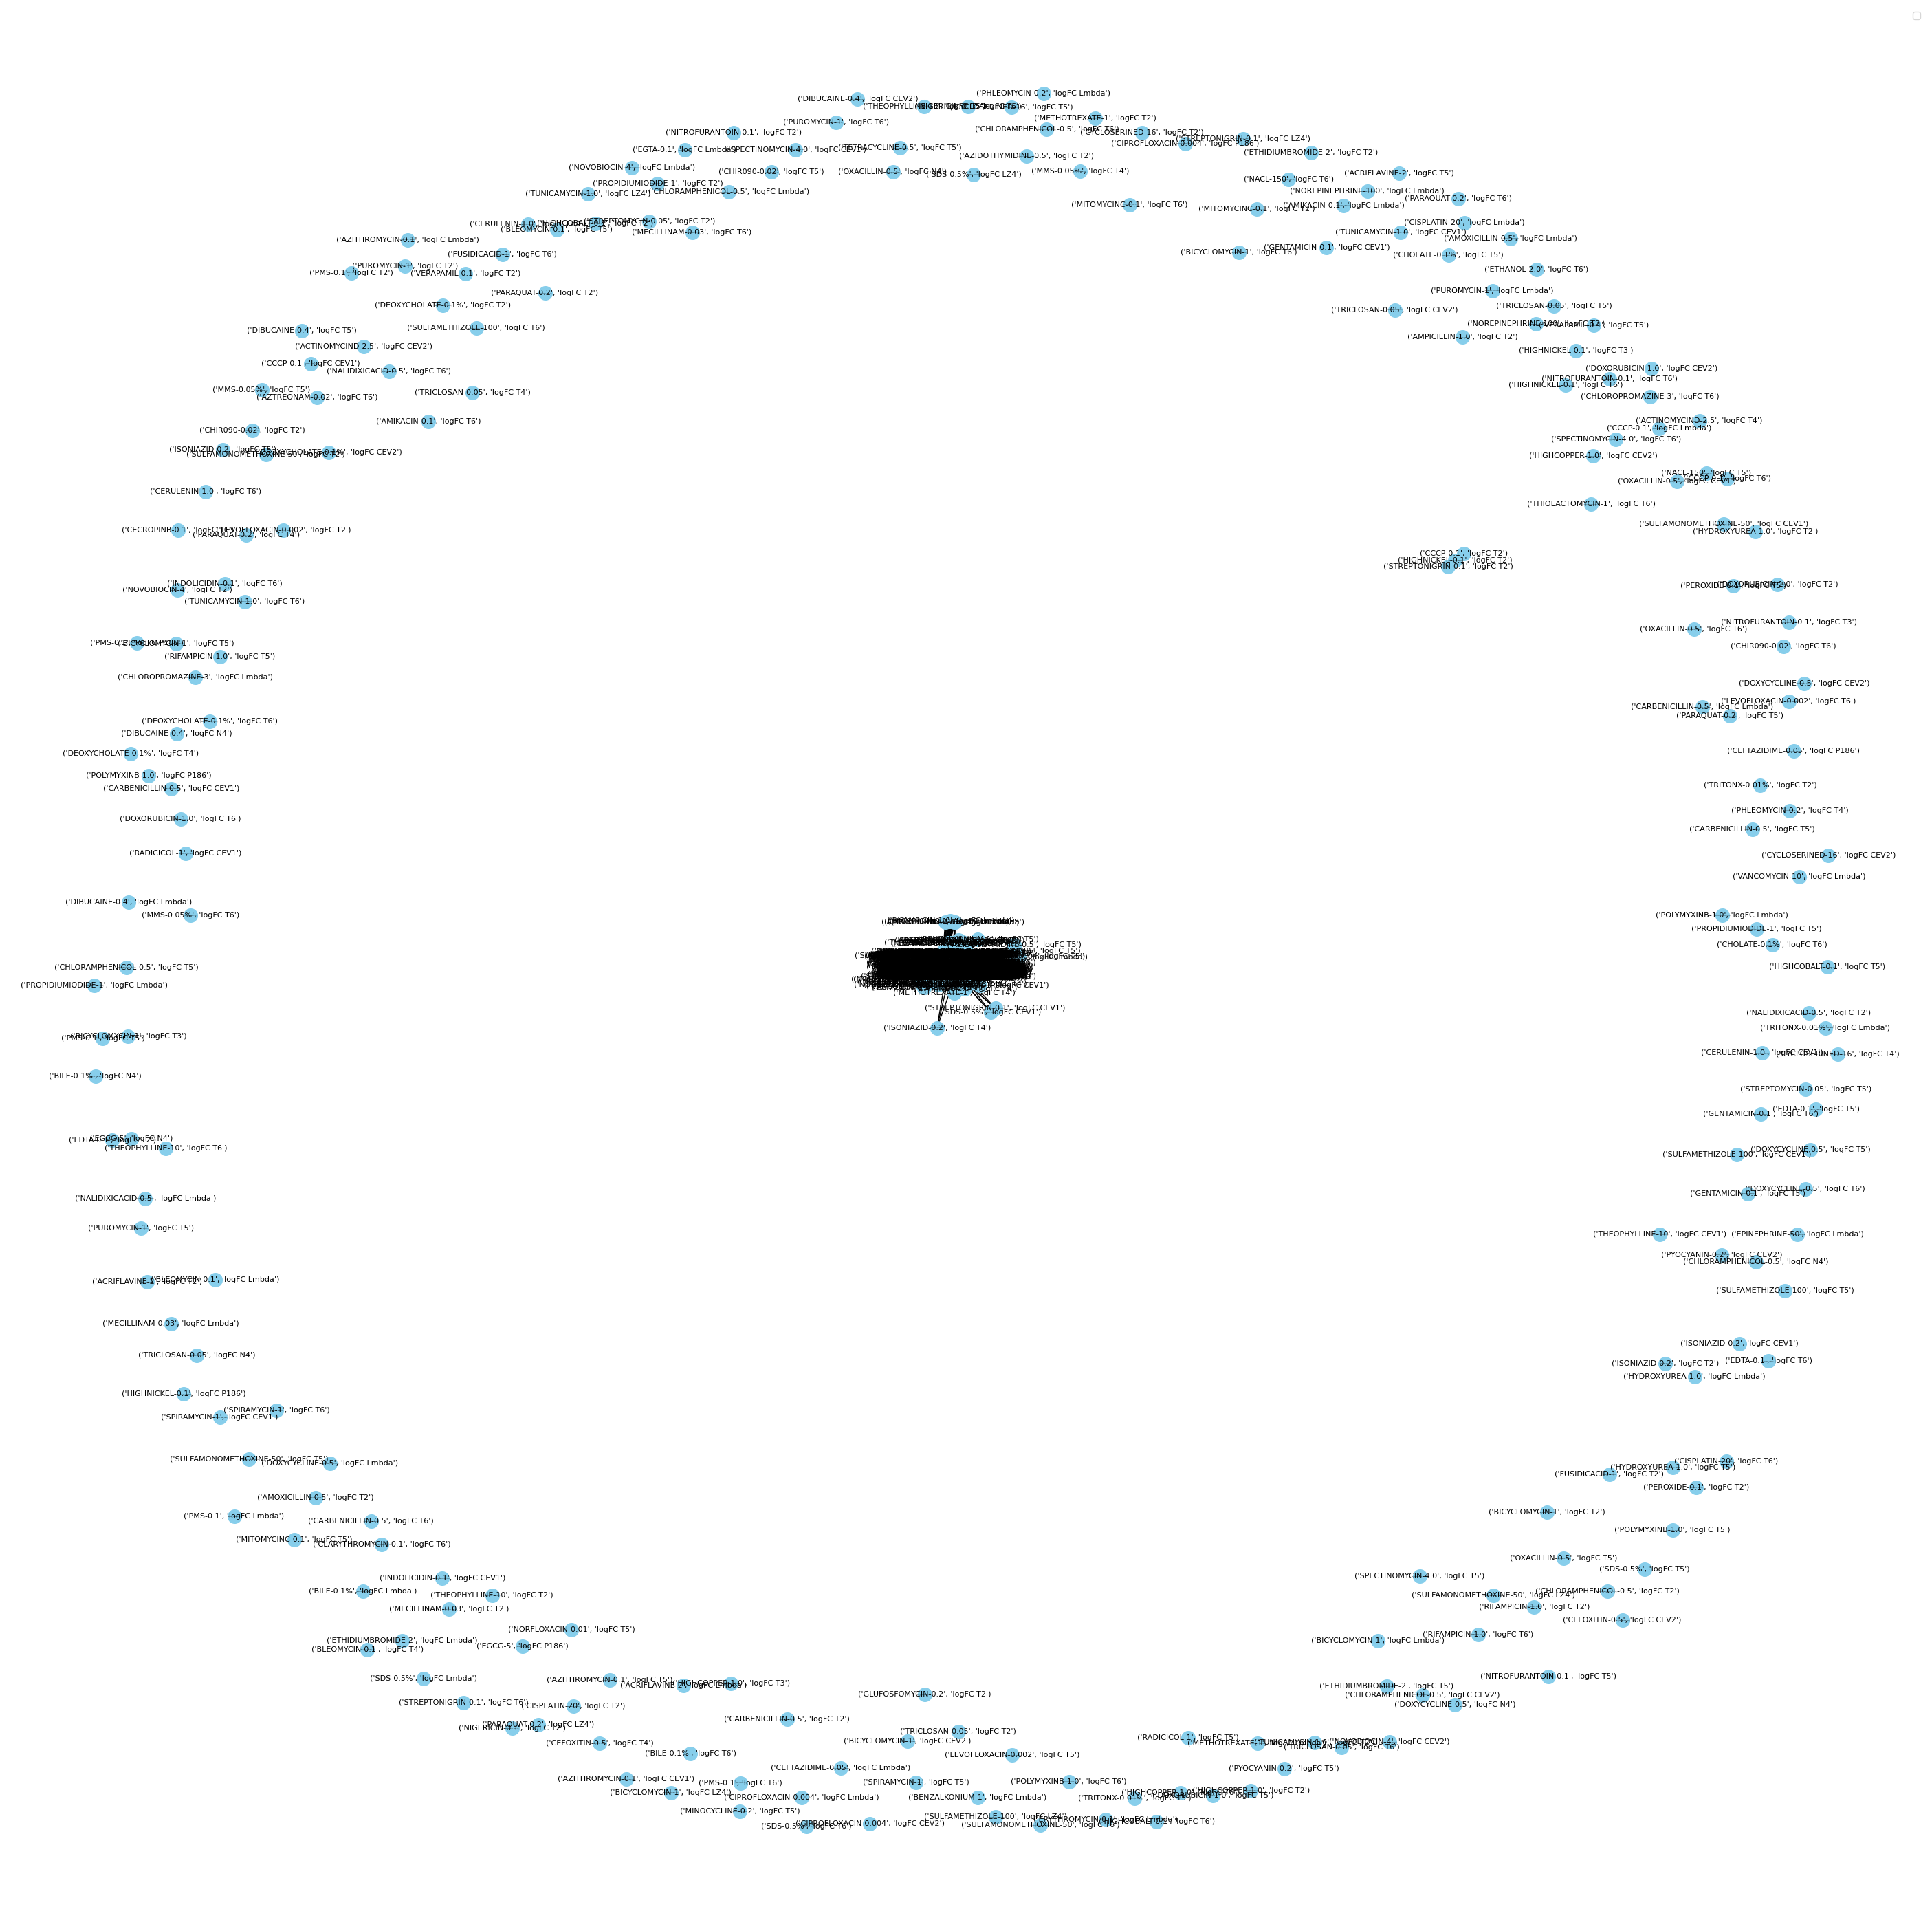

In [ ]:
#Step 4: Visualization of the whole plot
#Create a figure and axis object using plt.subplots()
fig, ax = plt.subplots(figsize=(36,36))

# Define layout
pos = nx.spring_layout(gene_network)

# Draw the network graph
nx.draw(gene_network, pos, with_labels=True, node_size=200, node_color='skyblue', font_size=8, ax=ax)

# Define drug labels
drug_labels = {drug: drug for drug in gene_network.nodes()}

# Draw drug labels
nx.draw_networkx_labels(gene_network, pos, labels=drug_labels, font_size=1, ax=ax)

# Customize and display the plot
plt.legend(scatterpoints=1)
plt.axis('off')

# Show the plot
plt.show()

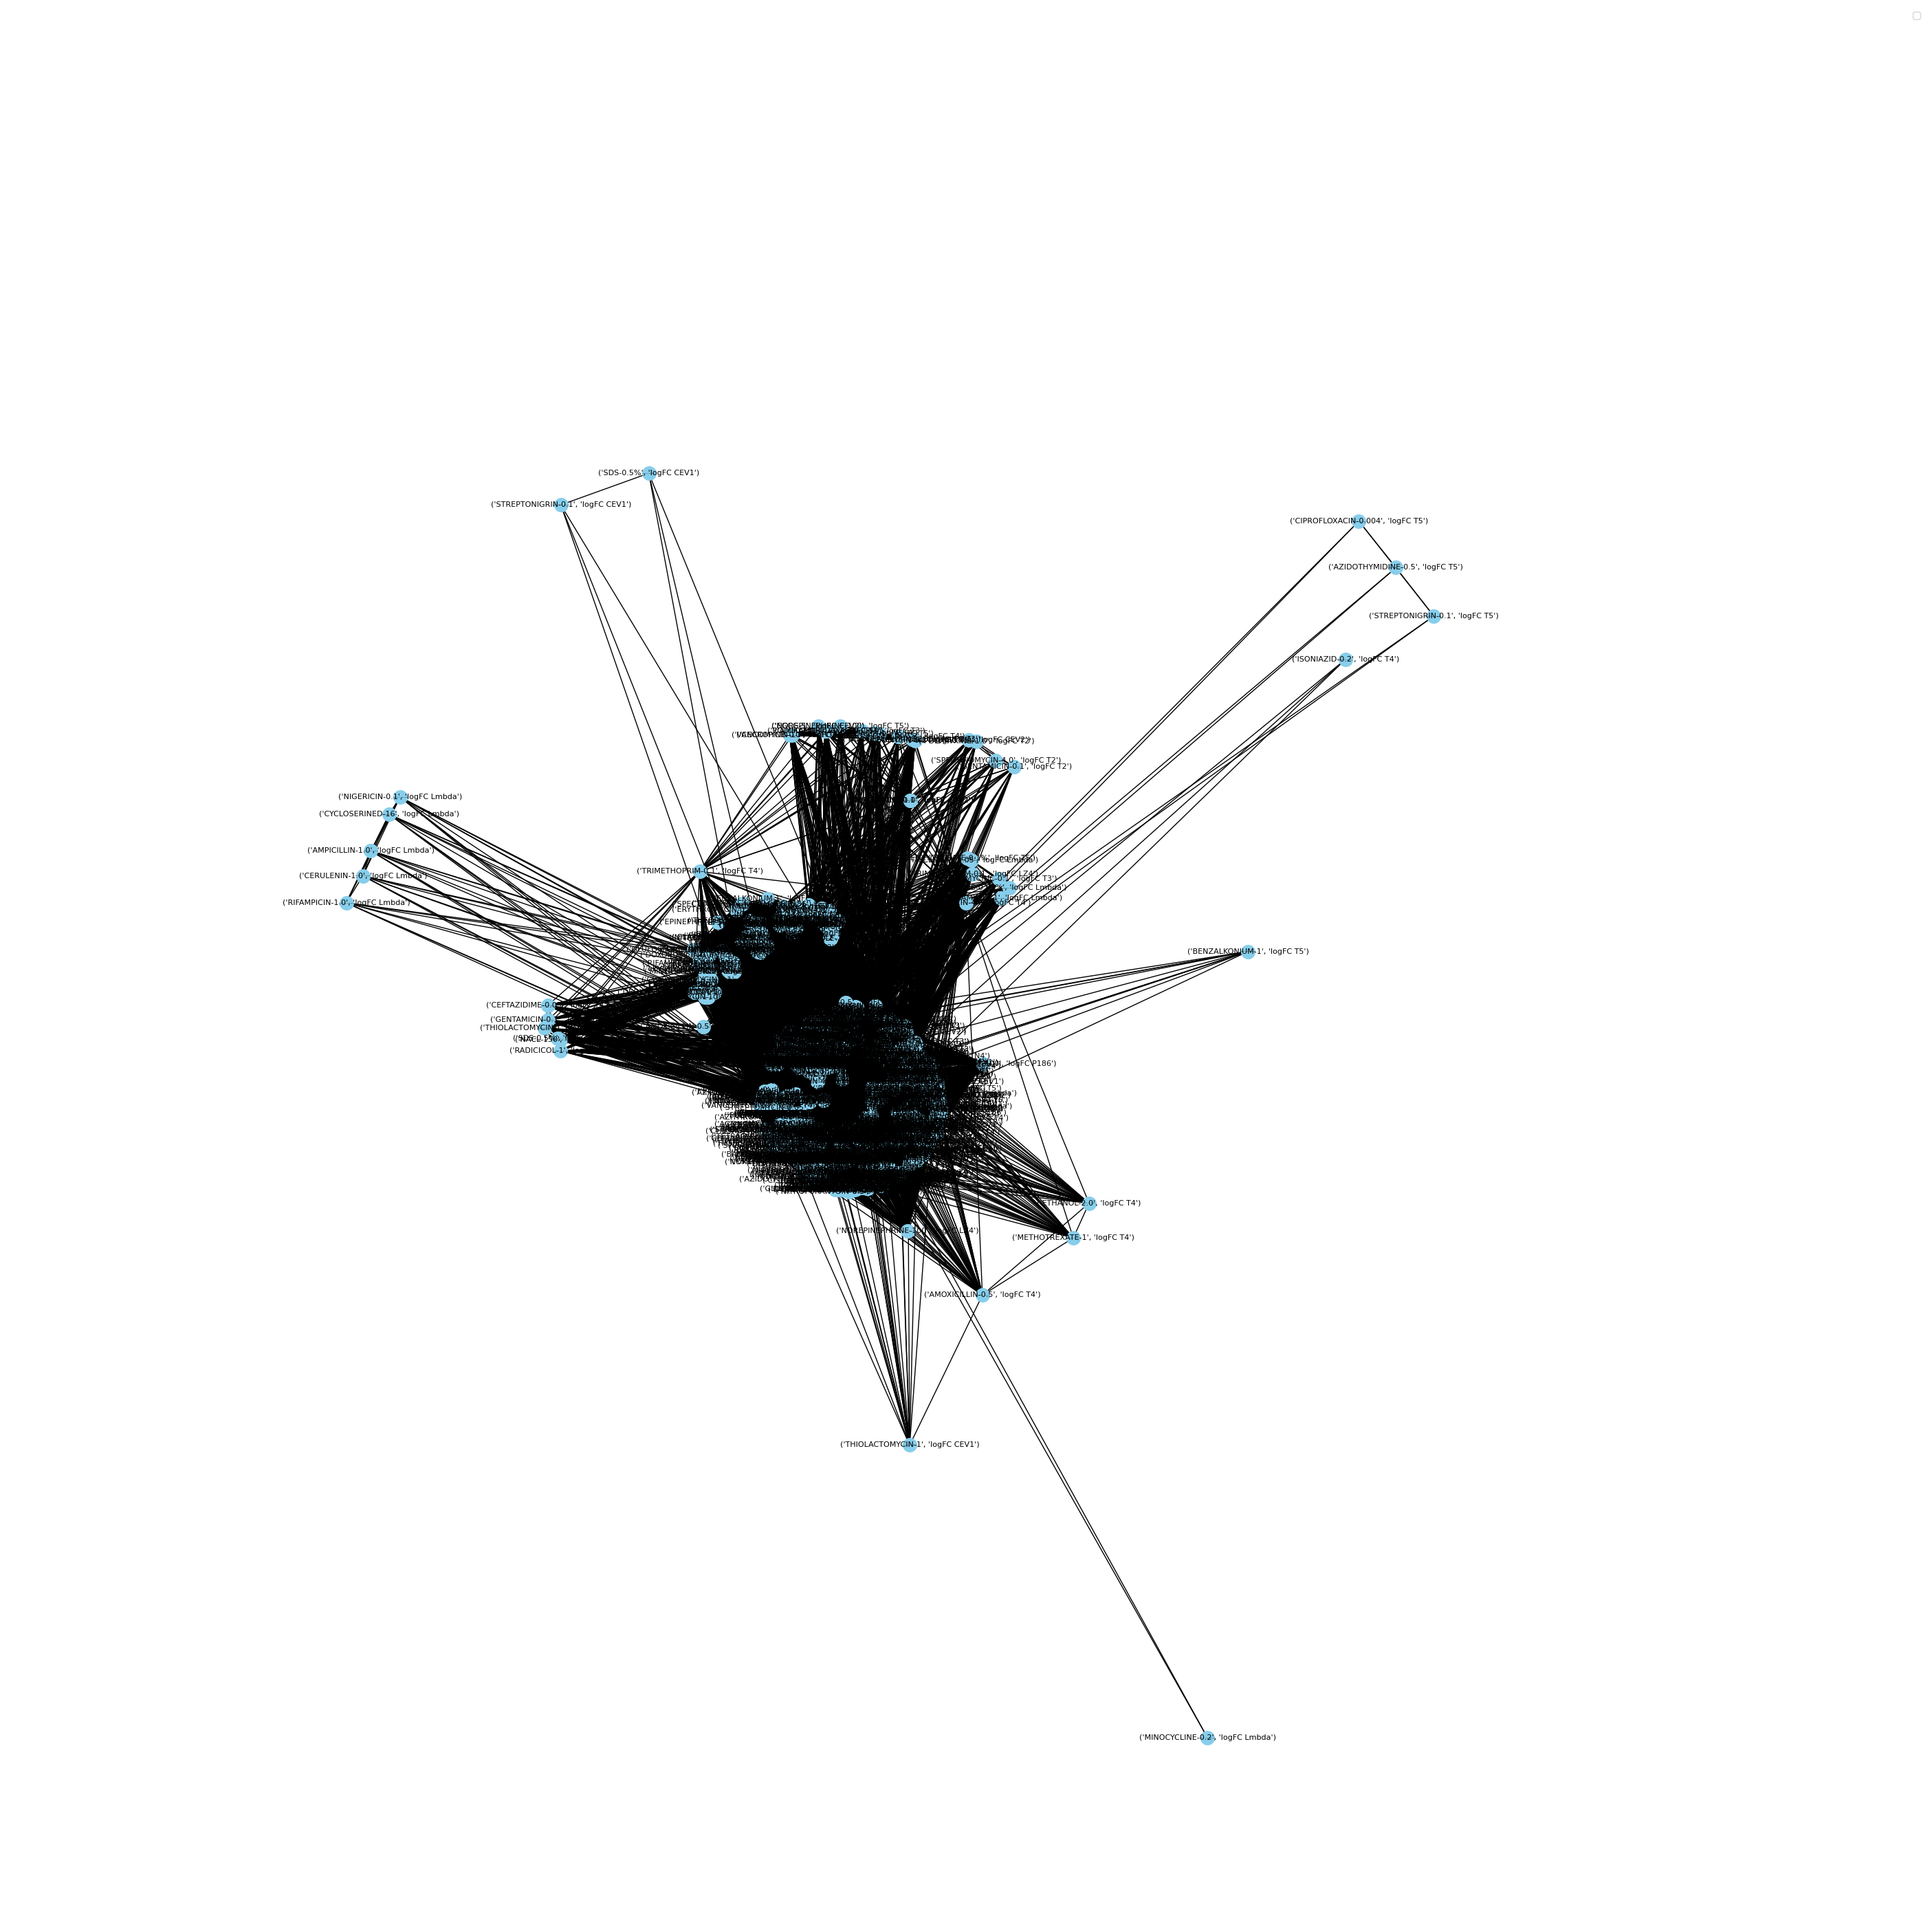

In [ ]:
#Step 5: Zoomed in plot to only visualize the nodes with connections.

#Create a figure and axis object using plt.subplots()
fig, ax = plt.subplots(figsize=(36,36))
pos = nx.spring_layout(gene_network)
nx.draw(gene_network, pos, with_labels=True, node_size=200, node_color='skyblue', font_size=8, ax=ax)
drug_labels = {drug: drug for drug in gene_network.nodes()}
nx.draw_networkx_labels(gene_network, pos, labels=drug_labels, font_size=1, ax=ax)
plt.legend(scatterpoints=1)
plt.axis('off')

#Zoom in
zoom_factor = 0.09  # Change this value to zoom in/out as desired

#Get current axis limits
x_min, x_max = ax.get_xlim()
y_min, y_max = ax.get_ylim()

#Calculate new axis limits for zooming
x_range = x_max - x_min
y_range = y_max - y_min

new_x_range = x_range * zoom_factor
new_y_range = y_range * zoom_factor

center_x = (x_max + x_min) / 2
center_y = (y_max + y_min) / 2

ax.set_xlim(center_x - new_x_range / 2, center_x + new_x_range / 2)
ax.set_ylim(center_y - new_y_range / 2, center_y + new_y_range / 2)

#Update the displayed plot
fig.canvas.draw()

#Show the modified plot
plt.show()

Part 8: Looking at the predicted synergistic and antagonistic combinations of antibiotics and bacteriophages obtained from running the INDIGO model.

In [ ]:
#Reading Excel file
synergy_path = os.path.join(GOOGLE_DRIVE_PATH, "data/synergy/phage_cutoff0.15_updated.xlsx")
phage_pred = pd.read_excel(synergy_path)

In [ ]:
#Data wrangling
#Confirming column names
print(phage_pred.columns)

#Adding new column with drug1-drug2 combined
phage_pred['combo'] = phage_pred['drug_1'] + "_" + phage_pred['drug_2']

#Removing single quotes from drug names
phage_pred['drug_1'] = phage_pred['drug_1'].str.replace("'", "")
phage_pred['drug_2'] = phage_pred['drug_2'].str.replace("'", "")

#Filtering data
remv_pred_N4 = phage_pred[phage_pred['drug_2'] != "H2O2"] #possibly outlier, removed for better visualization
remv_pred_N4 = remv_pred[remv_pred['drug_1'] != "N4"] #possibly outlier, removed for better visualization

Index(['drug_1', 'drug_2', 'it_1', 'it_2', 'it_3', 'it_4', 'it_5', 'it_6',
       'it_7', 'it_8', 'it_9', 'it_10', 'it_11', 'it_12', 'it_13', 'it_14',
       'it_15', 'it_16', 'it_17', 'it_18', 'it_19', 'it_20', 'it_21', 'it_22',
       'it_23', 'it_24', 'it_25', 'it_26', 'it_27', 'it_28', 'it_29', 'it_30',
       'it_31', 'it_32', 'it_33', 'it_34', 'it_35', 'it_36', 'it_37', 'it_38',
       'it_39', 'it_40', 'it_41', 'it_42', 'it_43', 'it_44', 'it_45', 'it_46',
       'it_47', 'it_48', 'it_49', 'it_50', 'avg', 'std_dev'],
      dtype='object')


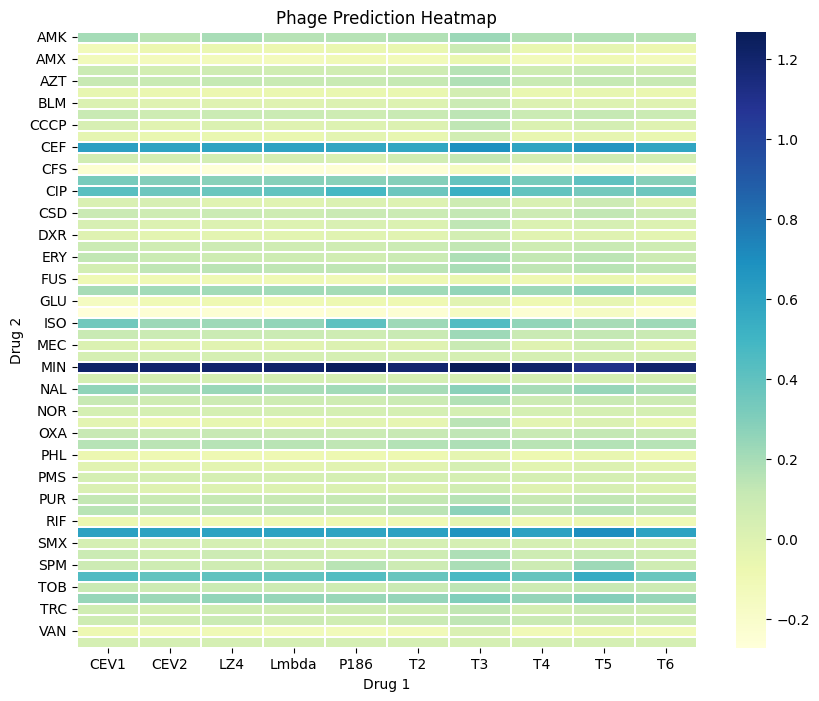

In [ ]:
#Plotting using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(remv_pred_N4.pivot_table(values='avg', index='drug_2', columns='drug_1'),
            cmap='YlGnBu', linewidths=0.25)
plt.xlabel('Drug 1')
plt.ylabel('Drug 2')
plt.title('Phage Prediction Heatmap')
plt.show()